# Imports

In [14]:
import pandas as pd
pd.options.display.max_columns = 50   # max displayed columns
pd.options.display.max_colwidth = 280 # width of a column

import matplotlib.pyplot as plt

import random
random.seed(42)

import numpy as np
np.random.RandomState(42)


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

# import nltk
# from nltk.probability import FreqDist
# from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
sw = stopwords.words('english')


import xgboost
# from imblearn.over_sampling import SMOTE 



In [15]:
## Uncomment below and run if you nltk throws up errors
#nltk.download('omw-1.4')

### Helper Functions

In [16]:
#Additional Helper functions can be found in 'src/'

import sys
sys.path.append( 'src' )
from pandas_functions import dataFrame_info
from documentParser import doc_preparer , getTopWordFreq 
from modelingResultPrettyPrinter import prettyPrintGridCVResults, prettyPrintCVScores

### Note: n_jobs

**Note:** To speed up running of model fit cells, the n_jobs parameter is set to a global variable. This can be set to -1 to allow access to the entirety of your machine's CPU resources for operations in this notebook (where applicable). This ***will*** make your machine essentially unusable until the operations have finished performing. Set this to None for regular operations

In [17]:
NB_n_jobs = -2

# Data: Loading, Cleaning, and Munging

## Describe data here!!!!

This dataset is a subset of webscraped twitter data that was gathered (presumably) at the SXSW festival that is held annually at Austin, Texas. It is self described as a meeting of music, tech and film.


This data was gathered from CrowdFlower. Per CrowdFlower:

Description:
>Judge Emotion About Brands and Products

Summary:
>Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion. Added: August 30, 2013 by Kent Cavender-Bares | Data Rows: 9093 Download Now

Source:
https://www.crowdflower.com/data-for-everyone/

## Loading

In [18]:
dataFolder_path = 'data/'
data_df = pd.read_csv(dataFolder_path+'judge_1377884607_tweet_product_company.csv')

In [19]:
data_df.head(3)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion


In [20]:
data_df.shape

(8721, 3)

## Cleaning

Let's rename the columns for ease of use. Note that `product` is a reserved word in Python; for the second column, initially titled `emotion_in_tweet_is_directed_at`, I use `product_name`.

In [21]:
data_df.rename(columns = {'tweet_text': 'text',
                     'emotion_in_tweet_is_directed_at': 'product_name',
                     'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'},
               inplace = True)

In [22]:
data_df.isna().sum()

text               1
product_name    5552
emotion            0
dtype: int64

Lots of nulls in `product_name`, which we'll have to deal with at one point or another, and exactly *one* null value in the `text` column. Let's check that out real quick...

In [23]:
data_df[data_df.text.isna()]

,text,product_name,emotion
6,NaN,NaN,No emotion toward brand or product


This record has no relevant information associated with it. No useful information can be drawn from it. Dropping this record

In [24]:
data_df.dropna(subset=['text'],inplace=True)

In [25]:
data_df.shape

(8720, 3)

## Munging

In [26]:
#dataFrame_info(data_df)

There is an extremely large number of nulls in product name, which we will have to account for. For the purpose of modeling, the columns we specifically care about are the `text` and `emotion` columns, since we are going to try and predict the emotional quotient of a tweet.

Let's get a look of how the target column (`emotion`) is distributed.

In [27]:
print(f"Emotion value counts:\n{data_df.emotion.value_counts()}")

Emotion value counts:
No emotion toward brand or product    5155
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: emotion, dtype: int64


There seems to be a significant imbalance in our data. We can confirm this by normalizing and visualizing the data

Emotion value counts (normalized):
No emotion toward brand or product    0.591170
Positive emotion                      0.329014
Negative emotion                      0.062500
I can't tell                          0.017317
Name: emotion, dtype: float64


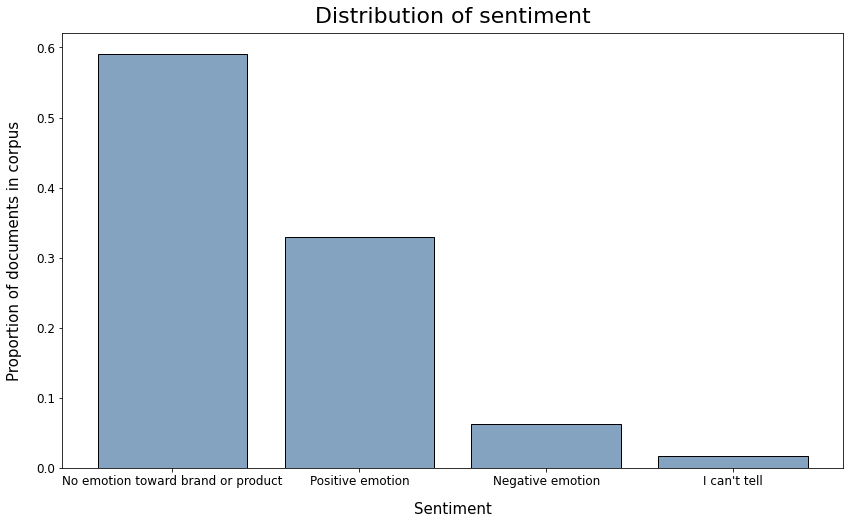

In [28]:
fig, ax = plt.subplots(figsize = (14, 8))

ax.bar(x = data_df.emotion.value_counts(normalize=True).index,
       height = data_df.emotion.value_counts(normalize=True).values,
       color = (0.2, 0.4, 0.6, 0.6),
       edgecolor = 'black')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.set_xlabel(xlabel="Sentiment",
              fontsize=15,
              labelpad=14)
ax.set_ylabel(ylabel="Proportion of documents in corpus",
              fontsize=15,
              labelpad=14)
ax.set_title(label="Distribution of sentiment",
             fontsize=22,
             pad=10);



print(f"Emotion value counts (normalized):\n{data_df.emotion.value_counts(normalize=True)}")

`I can't tell` makes up less than 2% of our dataset, and doesn't offer much more information in the way of word significance than the tweets labeled `No emotion toward brand or product`. We will drop records where `emotion` has been recorded as `I can't tell`.

In [29]:
data_df.drop(
    index = data_df[data_df.emotion == "I can't tell"].index,
    inplace = True)

data_df.shape

(8569, 3)

### StopWords

When working with webscraping and social data mining applications, or NLP problems in general, one of the problems that crops up is there is a large number of words that are commonly used. These words (such as 'a', 'are' etc) won't be able to uniquely identify with our `emotion` column since they are so widely used. \
We will be implementing nltk's stopwords module to remove such commonly used english words, here is a few examples of such words.

In [30]:
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

But we can improve upon this. To do so lets have a quick look at the most frequently used words across all tweets.

In [31]:
# Lower case all text, remove punctuations, ignore stop words, get word frequency
getTopWordFreq(data_df,'text',n=10,stop_words = sw)

[('sxsw', 9096),
 ('link', 4077),
 ('rt', 2925),
 ('ipad', 2836),
 ('google', 2329),
 ('apple', 2093),
 ('quot', 1582),
 ('iphone', 1492),
 ('store', 1397),
 ('new', 1057)]

<BarContainer object of 10 artists>

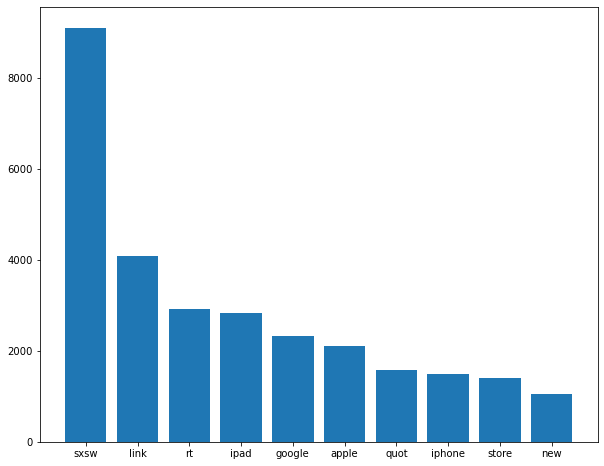

In [32]:
# Plot most frequent words
fig,ax = plt.subplots(figsize = (10,8))
num_of_bars = 10
viz_data = getTopWordFreq(data_df,'text',n=num_of_bars,stop_words = sw)

ax.bar(x = [word for word,freq in viz_data], 
      height = [freq for word,freq in viz_data])

Just by looking at this, we can see there is a high occurence of 
- venue specific words such  as `sxsw`
- twitter specific words such as `rt`
- brand or product specific words such as `iphone`

These words probably occur across our various sentiments and may not necessarily add any meaning, unless a majority of their occurence is associated with a particular `emotion`

Instead of dropping words that just occur at a high frequency across the entire corpus, we will drop words that occur at a high frequency across our positive and negative emotional quotient.

This should ensure we don't accidentally remove a word from the corpus that is overall heavily represented but is mostly represented in any 1 `emotion`

In [33]:
neg_df = data_df[data_df['emotion']=='Negative emotion']
pos_df = data_df[data_df['emotion']=='Positive emotion']

Sanity Check

In [34]:
neg_df.head(3)

,text,product_name,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
17,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative emotion


In [35]:
pos_df.head(3)

,text,product_name,emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [36]:
print('As an example. Here are the top 5 words:')
print(f"Entire DataFrame: {[word for word,freq in getTopWordFreq(data_df,'text',3,stop_words = sw)]}")
print(f"Positive Emotion: {[word for word,freq in getTopWordFreq(pos_df,'text',3,stop_words = sw)]}")
print(f"negative Emotion: {[word for word,freq in getTopWordFreq(neg_df,'text',3,stop_words = sw)]}")

As an example. Here are the top 5 words:
Entire DataFrame: ['sxsw', 'link', 'rt']
Positive Emotion: ['sxsw', 'ipad', 'link']
negative Emotion: ['sxsw', 'ipad', 'quot']


As you can tell, there is going to be a lot of crossover with certain terms (`sxsw`, `ipad` in our example above) which we should remove however, we'd want to retain words that are potentially more identifiable with a certain `emotion`. This is just the top 3 words, and we shall be using a larger set.

In [37]:
num_mostCommon_Words = 50
common_neg_words = [word for word,freq in getTopWordFreq(neg_df, 'text',num_mostCommon_Words,stop_words = sw)]
common_pos_words = [word for word,freq in getTopWordFreq(pos_df, 'text',num_mostCommon_Words,stop_words = sw)]
new_sw_words = list(set(common_neg_words).intersection(set(common_pos_words)))
print(len(new_sw_words))
new_sw_words[:10]

31


['austin',
 'pop',
 'network',
 'android',
 'quot',
 'app',
 'rt',
 'circles',
 'people',
 'sxsw']

We shall be appending this to our stopword list. As part of our `doc_preparer()` we shall be removing these words in the future

In [38]:
len(sw)

179

In [39]:
sw.extend(new_sw_words)
len(sw)

210

Lets have a look at the word distribution again

<BarContainer object of 10 artists>

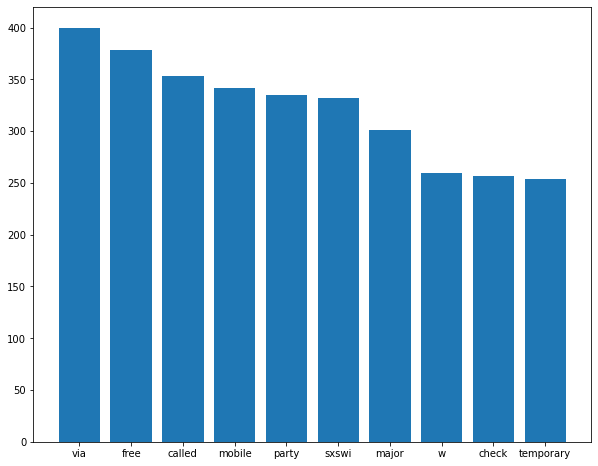

In [40]:
# Plot most frequent words
fig,ax = plt.subplots(figsize = (10,8))
num_of_bars = 10
viz_data = getTopWordFreq(data_df,'text',n=num_of_bars,stop_words = sw)

ax.bar(x = [word for word,freq in viz_data], 
      height = [freq for word,freq in viz_data])

Already one can tell the skew of the graph is reduced.

### Stemming

We shall be creating a column of a cleaned text string built off of the original tweet

In [ ]:
#data_df['stemmed_text'] = data_df['text'].map(lambda x:doc_preparer(x,stem=True))

In [ ]:
#data_df[['text','stemmed_text']].head(5)

### Label Encoding the emotion column

To help with our classification models, we shall use a label encoder to encode the target `emotion` into a more computer friendly numerical column

In [41]:
le = LabelEncoder()
data_df['sentiment_target'] = le.fit_transform(data_df.emotion)
le.classes_

array(['Negative emotion', 'No emotion toward brand or product',
       'Positive emotion'], dtype=object)

In [42]:
data_df[['emotion', 'sentiment_target']].head(10)

,emotion,sentiment_target
0,Negative emotion,0
1,Positive emotion,2
2,Positive emotion,2
3,Negative emotion,0
4,Positive emotion,2
5,No emotion toward brand or product,1
7,Positive emotion,2
8,Positive emotion,2
9,Positive emotion,2
10,Positive emotion,2


# Train-Test-Split

In [67]:
X = data_df['text']
y = data_df['sentiment_target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=42)

In [69]:
X_test_neg = X_test.to_frame()

In [70]:
X_test_neg['stemmed_text'] = X_test_neg['text'].map(lambda x:doc_preparer(x,stem=True))

In [71]:
X_test_neg.drop('text', axis=1, inplace=True)

In [54]:
Xfromcsv = pd.read_csv('data/backs_trans_fulltrain.csv')
Xfromcsv.set_index('Unnamed: 0', inplace=True)

In [57]:
Xfromcsv.rename(columns={"tweet_text": "text"}, inplace=True)

In [59]:
X_train_neg = X_train.to_frame()

In [60]:
X_train_neg

,text
3791,"Tech Check podcast -- #SxSW #Android passes #BlackBerry, a big Twitter #fail! -- {link} by @mention #sxsw #cnn"
4683,"In honor of Apple's #SXSW pop-up shop, here are some thoughts on how landlords &amp; leasing agents can utilize pop-up shops. {link}"
5800,"RT @mention Hoot! New Blog post: HootSuite Mobile for #SXSW ~ Updates for iPhone, BlackBerry &amp; Android {link}"
4879,RT @mention @mention 3 iPhone Apps We'll Be Using at South By Southwest Interactive {link} #SXSW #SXSWi
2804,"#sxsw: @mention intrvw @mention &quot;Schmidt [Google CEO] told me: u'r good at telling stories; go talk to lots of ppl, tell us what u hear&quot;"
...,...
5837,RT @mention I wish the apple store employees cheering for all the people in line at the pop up apple store would cheer me on while I do timesheets #SXSW
5286,RT @mention At #sxsw? We're giving away an iPad 2 to the creator of the most popular disc during interactive. Create a disc &amp; share on Twitter!
5488,RT @mention Find where @mention is playing at #SXSW on the #eventseekr app for Android. We got u! {link}
874,"Hey #SXSW movers and shakers, @mention is publishing a &quot;Poke the Box&quot; eBook next week. Get involved: {link}"


In [61]:
X_train_neg = pd.concat([X_train_neg, Xfromcsv])

In [63]:
X_train_neg['stemmed_text'] = X_train_neg['text'].map(lambda x:doc_preparer(x,stem=True))

In [65]:
X_train_neg.drop('text', axis=1, inplace=True)

In [72]:
X_train_neg

,stemmed_text
3791,tech check podcast sxsw android pass blackberri big twitter fail link sxsw cnn
4683,honor apple' sxsw pop shop thought landlord amp leas agent util pop shop link
5800,rt hoot new blog post hootsuit mobil sxsw updat iphon blackberri amp android link
4879,rt iphon app we'll use south southwest interact link sxsw sxswi
2804,sxsw intrvw quot schmidt googl ceo told u'r good tell stori go talk lot ppl tell us u hear quot
...,...
3218,lunch cnngrill view html develop trench android pain io slim sxsw
2501,new iphon car correct alreadi tri chang colleagu quot vissigot quot
3163,googl circl lame sxsw lt
65,visitor ipad design headach sxsw link


In [79]:
y_train

3791    2
4683    2
5800    1
4879    2
2804    1
       ..
5837    1
5286    1
5488    1
874     1
7397    0
Name: sentiment_target, Length: 5998, dtype: int32

In [76]:
y_negs = pd.DataFrame(np.zeros((360, 1)))

In [82]:
y_train_negs = y_train.append(y_negs[0])

In [93]:
cvec_rfc_neg_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('rfc',RandomForestClassifier(criterion='gini', max_depth=180, n_estimators=50, random_state=42)
   )
])

In [94]:
cvec_rfc_neg_pipe.fit(X_train_neg['stemmed_text'], y_train_negs)

Pipeline(steps=[('cvec', CountVectorizer()),
                ('rfc',
                 RandomForestClassifier(max_depth=180, n_estimators=50,
                                        random_state=42))])

In [99]:
cvec_rfc_neg_pipe.score(X_train_neg['stemmed_text'], y_train_negs)

0.9878892733564014

In [104]:
cr = classification_report(y_test, cvec_rfc_neg_pipe.predict(X_test_neg['stemmed_text']))
print(cr)

              precision    recall  f1-score   support

           0       0.59      0.22      0.32       185
           1       0.70      0.87      0.77      1553
           2       0.64      0.45      0.53       833

    accuracy                           0.68      2571
   macro avg       0.64      0.51      0.54      2571
weighted avg       0.67      0.68      0.66      2571



# Modeling

## `CountVectorizer()` with `MutinomialNB()`

In [ ]:
#Pipeline
cvec_mnb_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('mnb',MultinomialNB()
   )
])

#5 fold Cross Validation
cvec_mnb_cvResults = cross_validate(cvec_mnb_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(cvec_mnb_cvResults)

We can already see some significant overfitting. This might be due to such a small and imbalanced dataset.

## `TfidfVectorizer()` with `MutinomialNB()`

In [ ]:
#Pipeline
tvec_mnb_model_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
   ('mnb',MultinomialNB()
   )
])

#5 fold Cross Validation
tvec_mnb_cvResults = cross_validate(tvec_mnb_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(tvec_mnb_cvResults)

Using a TF-IDF vectorizer improves accuracy but at a major cost to the F1-score

## `CountVectorizer()` with `RandomForestClassifier()`

In [ ]:
#Pipeline
cvec_rfc_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('rfc',RandomForestClassifier(random_state=42)
   )
])

#5 fold Cross Validation
cvec_rfc_cvResults = cross_validate(cvec_rfc_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(cvec_rfc_cvResults)

This is model is severely overfitting but it performs marginally better than the `MultinomialNB()` model

## `TfidfVectorizer()` with `RandomForestClassifier()`

In [ ]:
#Pipeline
tvec_rfc_model_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
   ('rfc',RandomForestClassifier(random_state=42)
   )
])

#5 fold Cross Validation
tvec_rfc_cvResults = cross_validate(tvec_rfc_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(tvec_rfc_cvResults)

## `CountVectorizer()` with `GradientBoostingClassifier()`

In [ ]:
#Pipeline
cvec_gbc_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('gbc',GradientBoostingClassifier(random_state=42)
   )
])

#5 fold Cross Validation
cvec_gbc_cvResults = cross_validate(cvec_gbc_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(cvec_gbc_cvResults)

## `TfidfVectorizer()` with `GradientBoostingClassifier()`

In [ ]:
#Pipeline
tvec_gbc_model_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
   ('gbc',GradientBoostingClassifier(random_state=42)
   )
])

#5 fold Cross Validation
tvec_gbc_cvResults = cross_validate(tvec_gbc_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(tvec_gbc_cvResults)

## `CountVectorizer()` with `XGBRFClassifier()`

In [ ]:
#Pipeline
cvec_xgb_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('xgb',xgboost.XGBRFClassifier(random_state=42)
   )
])

#5 fold Cross Validation
cvec_xgb_cvResults = cross_validate(cvec_xgb_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(cvec_xgb_cvResults)

## `TfidfVectorizer()` with `XGBRFClassifier()`

In [ ]:
#Pipeline
tvec_xgb_model_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
   ('gbc',xgboost.XGBRFClassifier(random_state=42)
   )
])

#5 fold Cross Validation
tvec_xgb_cvResults = cross_validate(tvec_xgb_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(tvec_xgb_cvResults)

# Hypertuning best model

Our count vectorized > random forest model worked best. Hypertuning it

In [ ]:
params = {}
params['rfc__criterion'] = ['gini','entropy']
params['rfc__n_estimators'] = np.arange(50,250,50)
params['rfc__max_depth'] = np.arange(100,200,10)
# params['rfc__max_leaf_nodes']=[4000,4500,5000]

cvec_rfc_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('rfc',RandomForestClassifier(random_state=42)
   )
])

cvec_rfc_gs = GridSearchCV(estimator=cvec_rfc_model_pipe,
                           param_grid=params,
                           n_jobs=NB_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True)

cvec_rfc_gs.fit(X_train,y_train)
prettyPrintGridCVResults(cvec_rfc_gs)

In [ ]:
cvec_rfc_gs.best_params_

In [ ]:
cr = classification_report(y_test, cvec_rfc_gs.best_estimator_.predict(X_test))
print(cr)

Overall accuracy is around 69% with an F1-Score of 67%

In [ ]:
cm = confusion_matrix(y_test, cvec_rfc_gs.best_estimator_.predict(X_test))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_estimator(
        cvec_rfc_gs.best_estimator_,
        X_test,
        y_test,
        display_labels=le.classes_,
        cmap='OrRd',
        normalize='true',
        ax=ax
       ).ax_.set_title('Normalized Confusion Matrix')

As can be seen our model has a long way to go. Currently the model performs its worst with clasiffying `Negative emotion` and best at `No emotion toward brand or product`. This is primarily due to a heavy imbalance in the classes.
Techniques to over come the imbalance will need to be employed.

# Future Steps

Potential upsampling techniques to be utilised:
- Backtranslation on minority sample to augment the training set
- Synonymising the minority sample to augment the training set
- SMOTEing the the minority sample to augment the training set